<a href="https://colab.research.google.com/github/dtheod/Sarcasm-Text-Classification/blob/main/FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install tensorflow_text 
# !pip install contractions
# !pip install plotly
# !pip install pyyaml==5.4.1
# !pip install -q tf-models-official==2.7.0

In [4]:
#Download Glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-29 11:52:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-29 11:52:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-29 11:52:17--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from collections import Counter
import contractions
import numpy as np
import operator
import re
from official.nlp import optimization
import plotly.express as px
import nltk
from nltk.corpus import stopwords

In [6]:
github_url = "https://raw.githubusercontent.com/dtheod/Sarcasm-Text-Classification/main/data/"
train_data = pd.read_csv(github_url + "train.csv")
test_data = pd.read_csv(github_url + "test.csv")

In [7]:
def train_test_split(df, frac=0.1):
    test = df.sample(frac=frac, axis=0)
    train = df.drop(index=test.index)
    return train, test

In [8]:
train_data, val_data = train_test_split(train_data)

In [9]:
def balance_proc(df, set_name):
    df = (
        pd.DataFrame(df['label'].value_counts())
        .reset_index()
        .rename(columns = {'index':'label', 'label':'count'})
        .assign(Set = set_name)
        .replace(to_replace = 1, value = 'Fake News')
        .replace(to_replace = 0, value = 'Real News')
    ) 
    return df

balanced_labels_train = balance_proc(train_data, 'Train')
balanced_labels_val = balance_proc(val_data, 'Test')
bal_viz = pd.concat([balanced_labels_train, balanced_labels_val], axis = 0)
fig = px.bar(bal_viz, x="Set", y="count", color="label", title="Check Balance")
fig.show()

In [10]:
def contractions_func(x):
    try:
        n = contractions.fix(x, slang = True)
        return n
    except IndexError:
        pass

def preprocessing(data):
    new_data = (
        data
        .assign(boolean = lambda x: x['text'].apply(lambda x: isinstance(x,str)))
        .query('boolean == True')
        .filter(['label', 'text'])
        .rename(columns = {'text':'comment'})
        .assign(lengs = lambda x: x['comment'].apply(lambda x: len(x.split(" "))))
        .query("lengs >= 4")
        .assign(comment = lambda x:x['comment'].apply(lambda x: contractions_func(x)))
        .dropna()
        .assign(comment = lambda x: x['comment'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x.lower())))
        .reset_index(drop = True)
    )
    return new_data['comment'].tolist(), new_data['label'].tolist()

In [11]:
train_text, train_label = (train_data.pipe(preprocessing))
val_text, val_label = (val_data.pipe(preprocessing))

In [12]:
viz_df = (
    pd.DataFrame(Counter([len(x.split(" ")) for x in train_text]).items(), columns = ['n_words', 'count'])
    .sort_values(by = 'n_words', ascending = True)
    .assign(cum = lambda x: x['count'].cumsum())
    .assign(total = lambda x: x['count'].sum())
    .query("n_words <= 4000")
    .assign(percentage = lambda x:(x['cum']/x['total']) * 100)
)
fig = px.line(viz_df, x="n_words", y="percentage", title='Cumulative sum of words')
fig.add_hrect(y0=0, y1=95, x0 = 0,x1 = 0.6, line_width=0, fillcolor="red", opacity=0.2)
fig.show()

## Term Frequency - Removing stopwords

In [16]:
def term_frequency(comments):
    nltk.download("stopwords", quiet=True)
    stop_words = stopwords.words("english")
    tf_dict = {}
    for sentence in comments:
        sentence = re.sub(r"[^a-zA-Z]", " ", sentence.lower())
        split_words = sentence.split(" ")
        for word in split_words:
            if word not in stop_words and str(word) not in ['nan', '']:
                tf_dict[word] = tf_dict.setdefault(word, 0) + 1
    return sorted(tf_dict.items(), key=operator.itemgetter(1),reverse=True)

term_frequency_list = term_frequency(train_text)
fig = px.bar(pd.DataFrame(term_frequency_list, columns = ['word', 'frequency']).head(30),
             y='frequency', x='word', text_auto='.2s',
             title="Term Frequency - Removing stopwords")
fig.update_traces(textfont_size=12, textangle=0, textposition="outside", cliponaxis=False)
fig.show()

In [17]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train_ds = tf.data.Dataset.from_tensor_slices((train_text, train_label))
val_ds = tf.data.Dataset.from_tensor_slices((val_text, val_label))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# **Using the Glove Word Embeddings**

In [18]:
vocab_size = 50000
batch_size = 64

text_vectorization = TextVectorization(
        max_tokens = vocab_size,
        output_mode = 'int',
        output_sequence_length = 2500
)
text_vectorization.adapt(train_ds.map(lambda text, label: text))

In [19]:
def word_embeddings(embeddings_path):
  
  embeddings_index = dict()

  #open the embedding file
  with open(embeddings_path) as f:
    for line in f:
        values=line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float')
        embeddings_index[word] = coefs
    f.close()

  # get the mean and standard deviation of the embeddings weights
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()
  embed_size = all_embs.shape[1]

  #add the missing words to the embeddings and generate the random values

  vocabulary = text_vectorization.get_vocabulary()
  word_index = dict(zip(vocabulary, range(len(vocabulary))))

  nb_words = min(vocab_size, len(vocabulary))

  embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
  for word, i in word_index.items():
      if i >= vocab_size: continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None: embedding_matrix[i] = embedding_vector
  return embedding_matrix, embed_size

In [20]:
embedding_matrix, embed_size = word_embeddings("/content/glove.6B.200d.txt")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [21]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('val_accuracy') >= 0.98:
            print("Reached 98% then we can stop")
            self.model.stop_training = True

callbacks_list = [
                  
    tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5
    ),
    
    MyCallback(),

    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)

]

In [22]:
def glove_model():

  model_glove = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(vocab_size, embed_size, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name = "lstm_cel")),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

  model_glove.compile(loss='binary_crossentropy',
                      optimizer = tf.keras.optimizers.Adam(1e-4),
                      metrics=['accuracy'])
  return model_glove

model_glove = glove_model()
glove_history = model_glove.fit(train_ds, epochs = 10, validation_data = val_ds, callbacks = callbacks_list) 

Epoch 1/10
291/291 [==============================] - 176s 574ms/step - loss: 0.5249 - accuracy: 0.7416 - val_loss: 0.3670 - val_accuracy: 0.8336 - lr: 1.0000e-04
Epoch 2/10
291/291 [==============================] - 166s 572ms/step - loss: 0.3260 - accuracy: 0.8645 - val_loss: 0.3087 - val_accuracy: 0.8743 - lr: 1.0000e-04
Epoch 3/10
291/291 [==============================] - 167s 572ms/step - loss: 0.2762 - accuracy: 0.8881 - val_loss: 0.2840 - val_accuracy: 0.8787 - lr: 1.0000e-04
Epoch 4/10
291/291 [==============================] - 166s 572ms/step - loss: 0.2486 - accuracy: 0.9009 - val_loss: 0.2722 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 5/10
291/291 [==============================] - 167s 574ms/step - loss: 0.2355 - accuracy: 0.9037 - val_loss: 0.2511 - val_accuracy: 0.8991 - lr: 1.0000e-04
Epoch 6/10
291/291 [==============================] - 168s 575ms/step - loss: 0.2110 - accuracy: 0.9176 - val_loss: 0.2311 - val_accuracy: 0.9098 - lr: 1.0000e-04
Epoch 7/10
291/291 [==

# **Using Transformers from Tensorflow-Hub**

In [23]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [26]:
def build_transformer_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [31]:
transformer_model = build_transformer_model()

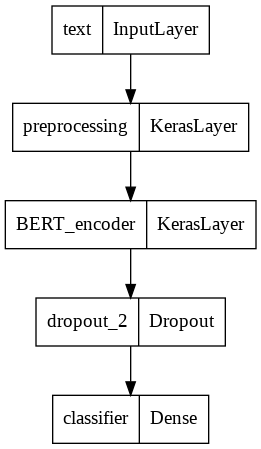

In [33]:
tf.keras.utils.plot_model(transformer_model)

In [34]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [35]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [36]:
transformer_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [38]:
history_transformer = transformer_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Epoch 1/10
291/291 [==============================] - 286s 980ms/step - loss: 0.1192 - binary_accuracy: 0.9543 - val_loss: 0.1525 - val_binary_accuracy: 0.9515
Epoch 2/10
291/291 [==============================] - 284s 974ms/step - loss: 0.0623 - binary_accuracy: 0.9772 - val_loss: 0.1563 - val_binary_accuracy: 0.9549
Epoch 3/10
291/291 [==============================] - 284s 977ms/step - loss: 0.0379 - binary_accuracy: 0.9870 - val_loss: 0.1835 - val_binary_accuracy: 0.9563
Epoch 4/10
291/291 [==============================] - 284s 977ms/step - loss: 0.0209 - binary_accuracy: 0.9931 - val_loss: 0.1825 - val_binary_accuracy: 0.9646
Epoch 5/10
291/291 [==============================] - 284s 977ms/step - loss: 0.0112 - binary_accuracy: 0.9964 - val_loss: 0.2052 - val_binary_accuracy: 0.9646
Epoch 6/10
291/291 [==============================] - 282s 969ms/step - loss: 0.0070 - binary_accuracy: 0.9977 - val_loss: 0.2556 - val_binary_accuracy: 0.9612
Epoch 7/10
291/291 [====================